# Toy Problem in Hierarchical Surrogate Modeling

Many predictions in cosmology are fundamentally predictions about *populations*, rather than predictions for the outcomes of individual events or objects. So, for example, we might want to predict the mass function of a simulated population of halos, or a correlation function computed from a finite set of particles in a simulated density field. 

In this toy problem, we will build a fast surrogate model for generating populations of satellite galaxies. In particular, we will build a generative model for the spatial distribution of satellite galaxies orbiting around their associated central galaxy. The classical technique for doing that is via the [transformation of probabilities](https://github.com/jbailinua/probability/). 

In this Monte Carlo technique, we need a model for the CDF of the radial profile, $M(<r\vert\beta_{\rm j})=p,$ where $r$ is the radial distance of the satellite from its central, and $\{\beta_{\rm j}\}$ are the parameters specifying the shape of the radial profile; since $M(<r)$ is the CDF, then we have $p\in(0, 1);$ it is typical to normalize $r$ by the outermost boundary of the dark matter halo that hosts the central, $R_{\rm halo},$ so that the model is formulated according to $M(<x\vert\beta_{\rm j})=p,$ with $x\equiv r/R_{\rm halo}\in(0, 1).$

In order to generate a Monte Carlo realization of one of these profiles, what we actually need is the _inverse_ CDF, $M^{-1}(p\vert\beta_{\rm j})\equiv\mathcal{G}(p\vert\beta_{\rm j})=x.$ Once we have $\mathcal{G}(p\vert\beta_{\rm j}),$ then generating Monte Carlo realizations is trivial: we just draw a uniform random variable $p$ for each orbiting satellite, and the function $\mathcal{G}$ provides the radial position $x$ of our satellites.

For our radial profile model, we will use the profiles with a splashback feature taken from [Diemer & Kravtsov (2014)](https://arxiv.org/abs/1401.1216)

$\rho(r) = \rho_{\rm inner}(r)\times f_{\rm trans}(r).$

$\rho_{\rm inner}(r) = \rho_{\rm Einasto}(r) = \rho_{\rm s}\exp\left(\frac{2}{\rm a}\left[(r/r_{\rm s})^{\rm a}-1\right]\right)$

$f_{\rm trans} = \left[1 + (\frac{r}{r_{\rm t}})^{\rm b}\right]^{\rm -g/b}$

The next cell shows what a few of these profiles $M(<x\vert\beta_{\rm j})=p,$ look like for a few choices of parameters $\{\beta_{\rm j}\}=\{r_{\rm s}, {\rm a, b, g}\}.$


## Training data for a surrogate model of Halo profiles w/ splashback

These data can be found at the following URL:

https://portal.nersc.gov/project/hacc/aphearin/splashback_training/

Alternatively, the script generating these data can be found in the `hierarchical_surrogate_modeling` directory of [the workshop repo on GitHub.](https://github.com/ArgonneCPAC/StatMLmeet)

In [1]:
%matplotlib inline

In [2]:
r_by_rt = np.load("DATA/r_by_rt.npy")
data = np.load("DATA/dk14_ds_tabulation.npy")
rs = data[:, 0]
alpha = data[:, 1]
beta = data[:, 2]
gamma = data[:, 3]

log_menc = data[:, 4:]

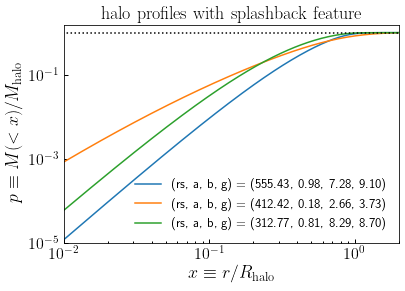

In [3]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.01, 2)
ylim = ax.set_ylim(1e-5, 1.5)
__=ax.loglog()

iplot = 0
msg = '(rs, a, b, g) = ({0:.2f}, {1:.2f}, {2:.2f}, {3:.2f})'
label0 = msg.format(rs[iplot], alpha[iplot], beta[iplot], gamma[iplot])
__=ax.plot(r_by_rt, 10**log_menc[iplot, :], label=label0)

iplot = 300
msg = '(rs, a, b, g) = ({0:.2f}, {1:.2f}, {2:.2f}, {3:.2f})'
label1 = msg.format(rs[iplot], alpha[iplot], beta[iplot], gamma[iplot])
__=ax.plot(r_by_rt, 10**log_menc[iplot, :], label=label1)

iplot = 3000
msg = '(rs, a, b, g) = ({0:.2f}, {1:.2f}, {2:.2f}, {3:.2f})'
label2 = msg.format(rs[iplot], alpha[iplot], beta[iplot], gamma[iplot])
__=ax.plot(r_by_rt, 10**log_menc[iplot, :], label=label2)

xlabel = ax.set_xlabel(r'$x\equiv r/R_{\rm halo}$')
ylabel = ax.set_ylabel(r'$p\equiv M(<x)/M_{\rm halo}$')
title = ax.set_title(r'${\rm halo\ profiles\ with\ splashback\ feature}$')
__=ax.plot(np.logspace(-5, 5, 1000), np.ones(1000), ':', color='k')
leg = ax.legend(fontsize=13)
fig.savefig('menc_dk14.png', bbox_extra_artists=[xlabel, ylabel], 
            bbox_inches='tight', dpi=200)


## Generating Monte Carlo realizations

The way we will actually use these radial profiles is in a hierarchical forward model, in which the model generates a Monte Carlo realization of a proposed distribution of satellites, and then that synthetic population is compared to the corresponding population in observational data. As we said above, that actually requires the _inverse_ CDF, $\mathcal{G}(p\vert\beta_{\rm j}),$ and so it is the function $\mathcal{G}$ for which we will build a surrogate model.

The next cell shows how to use the inverse CDF to generate a Monte Carlo realization of a radial profile for a couple of different parameter sets $\beta.$

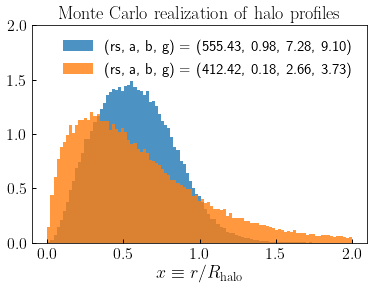

In [4]:
npts_to_generate = int(1e5)
pran = np.random.random(npts_to_generate)
xran = np.interp(np.log10(pran), log_menc[0, :], np.log10(r_by_rt))
xran2 = np.interp(np.log10(pran), log_menc[300, :], np.log10(r_by_rt))

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 2)
xbins = np.linspace(0, 2, 100)
__=ax.hist(10**xran, bins=xbins, density=True, alpha=0.8, label=label0)
__=ax.hist(10**xran2, bins=xbins, density=True, alpha=0.8, label=label1)

xlabel = ax.set_xlabel(r'$x\equiv r/R_{\rm halo}$')
title = ax.set_title(r'${\rm Monte\ Carlo\ realization\ of\ halo\ profiles}$')
leg = ax.legend()

## Surrogate modeling

The standard approach to modeling $\mathcal{G}(p\vert\beta_{\rm j})\equiv M^{-1}(p\vert\beta_{\rm j})$ is simply to discretize $\beta_{\rm j},$ to tabulate look tables for each disretized set of parameters, and to numerically invert $M(x\vert\beta_{\rm j}).$ Mechanically, this works fine in one or two dimensions, but quickly becomes unworkable in higher dimensional problems. Our profiles $M(x\vert\beta_{\rm j})$ are determined by $4$ parameters, and so we will use the traditional lookup table approach to generate training data for our surrogate.  The training data loaded in Cell 3 should be a good place to start for this toy problem.

## Broader context and performance needs

When using cosmological simulations to make predictions for the distribution of astronomically observed galaxies, it is common for the modeling to take place in two distinct phases. The first phase is to run an extremely expensive gravity-only simulation, which makes predictions for the distribution of dark matter halos. The second phase is to apply additional modeling to those halos, to account for astrophysics that was not included in the simulation itself. This challenge problem is primarily concerned with this second phase of modeling, which is done at fixed cosmology.

A cosmological simulation has millions to billions of dark matter halos. And these phase-two models are applied on a per-halo basis, so that predictions can be made for the statistics of the halo population. For this reason, it can be highly beneficial to build emulators/surrogates for the models applied to each individual halo. The surrogate models provide stand-ins for how the actual models augment/modify each member of the large halo population. 

For the *accuracy* of the surrogate model, we can usually tolerate errors at the $\sim1-2\%$ level without contributing too much to the overall error budget. For the performance of the model, the training time is not so important as the *evaluation time*: if our simulation had a billion halos, that would mean we'd need to evaluate our surrogate model a billion times in order to make the prediction for the statistics of the halo population. While a small GP might be too inaccurate, a deep neural network with a complex topology would be too expensive to evaluate so many times just to make a *single* prediction for the halo population.

What makes this modeling *hierarchical* is that we want to make more than a single prediction. We will need to make millions of such predictions, where each prediction is for some summary statistic of the galaxy population that is generated by applying our surrogate model(s) to each individual halo in the simulation. So, at a higher level of the hierarchy, we have a model with parameters $\{\alpha_{\rm i}\},$ and we have some modeling function $\mathcal{F}_{\alpha_i}$ that maps parameters $\{\beta_{\rm j}\}$ onto each halo; at the next level of the hierarchy, we have functions $\mathcal{G}_{\beta_{\rm j}}$ that are applied to each halo; it is the functions $\mathcal{G}_{\beta_{\rm j}}$ that transform the halo population into a galaxy population; from the generated galaxy population, we construct a single summary statistic that represents the prediction of the model specified by $\{\alpha_{\rm i}\};$ the functions $\mathcal{G}_{\beta_{\rm j}}$ are the functions for which we need fast-evaluating surrogate models. 

In the progression of the hierarchy, we want to carry out Bayesian inference on the parameters $\{\alpha_{\rm i}\}.$ The $\alpha$ parameters could be as simple as specifying a stellar-mass-to-halo-mass relation, or as complicated as the parameters regulating the behavior of a complex system of ODEs or PDEs (like in traditional "semi-analytic modeling" of galaxies). In our problem, the $\alpha$ parameters will control the behavior of a function $\mathcal{F}_\alpha$ that maps distinct values of $\beta_{\rm j}=\{r_{\rm s}, {\rm a, b, c}\}$ onto each dark matter halo. Conducting Bayesian inference on the $\alpha$ parameters may require computing a million likelihood evaluations in an MCMC, for example. 

For the computation of each likelihood, the way we make predictions that can be compared to data is to generate a synthetic galaxy population, and to compare some summary statistic of that synthetic galaxy population to the corresponding summary statistic measured in real data. Each individual computation of the $\{\alpha_{\rm i}\}$-model likelihood therefore requires evaluation of the model $\mathcal{G}_{\beta_{\rm j}}$ on each of the million-to-billion halos. 

This is why this set of science applications benefits so much from surrogate models that, once trained, *evaluate very quickly in batches.* The functions $\mathcal{G}_{\beta_{\rm j}}$ are typically analytical functions, numerical integrals, or solutions to ODEs. And while these functions themselves are typically too expensive to run in the MCMC over the parameters $\{\alpha_{\rm i}\},$ on the other hand the $\mathcal{G}_{\beta_{\rm j}}$ functions are usually cheap enough to evaluate $\mathcal{O}(10^{5-6})$ times without too much effort (particularly if the surrogate models have implementations that are performant on GPUs), and so in these applications there is no problem at all generating copious amounts of extremely high-quality training data. 